#### Dataset: CIFAR-10 

##### Image classification using customized Net architecture without data augmentation

This code trains a convolutional neural network (CNN) on the CIFAR-10 dataset using PyTorch.
First, it imports PyTorch and its required modules as well as the datasets and transforms modules from torchvision.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets

There are two sets of transformations, one for the training set and one for the test set. The training set transformations include random cropping, random horizontal flipping, converting the data to a tensor, and normalizing the data. The test set transformations only include converting the data to a tensor and normalizing it. The code then loads the CIFAR-10 dataset using the datasets.CIFAR10 class from torchvision. It uses the train=True argument to load the training set and train=False to load the test set. It also specifies the root directory for the data, whether to download the data if it doesn't exist, and the transformations to be applied to the data. It then creates data loaders for the training set and test set using the DataLoader class from PyTorch, which allows the data to be loaded in batches and shuffled during training.


In [2]:

transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True, num_workers=2)

testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False, num_workers=2)


Files already downloaded and verified
Files already downloaded and verified


Next, the code defines the CNN architecture using the nn.Module class from PyTorch. The CNN consists of six convolutional layers, each followed by batch normalization, ReLU activation, and max pooling. The output of the sixth convolutional layer is then flattened and passed through two fully connected layers with ReLU activation, and the final output layer has 10 nodes, corresponding to the 10 classes in the CIFAR-10 dataset.


In [3]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu1 = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.relu2 = nn.ReLU(inplace=True)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.relu3 = nn.ReLU(inplace=True)
        self.conv4 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(128)
        self.relu4 = nn.ReLU(inplace=True)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv5 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn5 = nn.BatchNorm2d(256)
        self.relu5 = nn.ReLU(inplace=True)
        self.conv6 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.bn6 = nn.BatchNorm2d(256)
        self.relu6 = nn.ReLU(inplace=True)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(256 * 4 * 4, 1024)
        self.relu7 = nn.ReLU(inplace=True)
        self.dropout1 = nn.Dropout()
        self.fc2 = nn.Linear(1024, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.pool1(x)
        x = self.conv3(x)
        x = self.bn3(x)
        x = self.relu3(x)
        x = self.conv4(x)
        x = self.bn4(x)
        x = self.relu4(x)
        x = self.pool2(x)
        x = self.conv5(x)
        x = self.bn5(x)
        x = self.relu5(x)
        x = self.conv6(x)
        x = self.bn6(x)
        x = self.relu6(x)
        x = self.pool3(x)
        x = x.view(-1, 256 * 4 * 4)
        x = self.fc1(x)
        x = self.relu7(x)
        x = self.dropout1(x)
        x = self.fc2(x)
        return x


The code then sets the device to either CUDA or CPU depending on whether a GPU is available, instantiates the CNN, the cross entropy loss criterion, and the stochastic gradient descent optimizer with a learning rate of 0.1, momentum of 0.9, and weight decay of 1e-4. Finally, the code trains the CNN for 20 epochs using a nested for loop. In each epoch, it iterates over the training set, loads the input data and labels, sends them to the device, performs forward and backward passes through the CNN to compute the loss, updates the parameters using the optimizer, and tracks the running loss. Every 100 iterations, it prints the epoch number, batch number, and running loss. After training, it evaluates the accuracy of the CNN on the test set by iterating over the test set, loading the input data and labels, sending them to the device, computing the outputs of the CNN, and comparing the predicted labels to the true labels. It then prints the accuracy of the CNN on the test set.


In [4]:

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

net = Net().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9, weight_decay=1e-4)

import time

start_time = time.time()
for epoch in range(20):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 100 == 99:
            print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 100))
            running_loss = 0.0

print('Finished Training')
print('Finished training in %.3f seconds' % (time.time() - start_time))



[1,   100] loss: 2.674
[1,   200] loss: 2.271
[1,   300] loss: 2.199
[1,   400] loss: 2.123
[1,   500] loss: 2.083
[1,   600] loss: 2.041
[1,   700] loss: 1.995
[2,   100] loss: 1.951
[2,   200] loss: 1.959
[2,   300] loss: 1.921
[2,   400] loss: 1.886
[2,   500] loss: 1.857
[2,   600] loss: 1.816
[2,   700] loss: 1.759
[3,   100] loss: 1.708
[3,   200] loss: 1.683
[3,   300] loss: 1.640
[3,   400] loss: 1.598
[3,   500] loss: 1.558
[3,   600] loss: 1.573
[3,   700] loss: 1.502
[4,   100] loss: 1.483
[4,   200] loss: 1.471
[4,   300] loss: 1.415
[4,   400] loss: 1.376
[4,   500] loss: 1.373
[4,   600] loss: 1.319
[4,   700] loss: 1.327
[5,   100] loss: 1.255
[5,   200] loss: 1.204
[5,   300] loss: 1.256
[5,   400] loss: 1.195
[5,   500] loss: 1.171
[5,   600] loss: 1.183
[5,   700] loss: 1.128
[6,   100] loss: 1.064
[6,   200] loss: 1.093
[6,   300] loss: 1.051
[6,   400] loss: 1.028
[6,   500] loss: 1.022
[6,   600] loss: 1.028
[6,   700] loss: 0.996
[7,   100] loss: 0.974
[7,   200] 

In [7]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (100 * correct / total))
print('Finished testing in %.3f seconds' % (time.time() - start_time))


Accuracy of the network on the 10000 test images: 79 %
Finished testing in 14636.301 seconds


In [8]:
import numpy as np
from sklearn.metrics import confusion_matrix

# Evaluate on test set
net.eval()
y_true = []
y_pred = []
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        y_true += labels.cpu().numpy().tolist()
        y_pred += predicted.cpu().numpy().tolist()

# Generate confusion matrix
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
conf_matrix = confusion_matrix(y_true, y_pred)

# Print confusion matrix
print("Confusion matrix:")
print(np.array2string(conf_matrix, separator=', ', 
                      formatter={'int': lambda x: f"{x:3d}"}))

# Print accuracy
accuracy = 100 * correct / total
print(f"Accuracy: {accuracy:.2f}%")


Confusion matrix:
[[837,   2,  25,  10,   9,   0,   3,   7,  86,  21],
 [ 21, 831,   3,   5,   0,   0,   0,   1,  70,  69],
 [ 84,   1, 706,  61,  45,  16,  26,  35,  16,  10],
 [ 25,   3,  32, 733,  28,  60,  15,  46,  30,  28],
 [ 21,   0,  45,  45, 747,   8,  13, 107,   7,   7],
 [ 16,   1,  37, 188,  19, 634,   3,  79,  10,  13],
 [ 20,   5,  36,  86,  29,   5, 763,  16,  18,  22],
 [ 22,   2,  18,  36,  14,  12,   1, 883,   5,   7],
 [ 43,   6,   2,  10,   0,   2,   1,   1, 924,  11],
 [ 31,  23,   7,   7,   1,   1,   0,   4,  52, 874]]
Accuracy: 79.32%


C:\Users\mimis\AppData\Local\Temp\ipykernel_18556\1422698640.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + list(range(10)))
C:\Users\mimis\AppData\Local\Temp\ipykernel_18556\1422698640.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + list(range(10)))


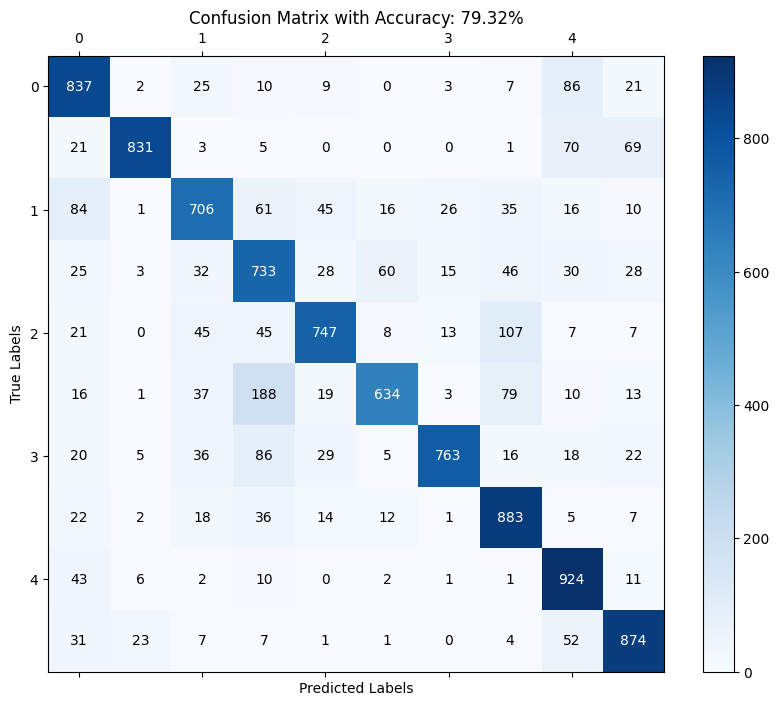

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

confusion_matrix = np.array([
    [837,   2,  25,  10,   9,   0,   3,   7,  86,  21],
    [ 21, 831,   3,   5,   0,   0,   0,   1,  70,  69],
    [ 84,   1, 706,  61,  45,  16,  26,  35,  16,  10],
    [ 25,   3,  32, 733,  28,  60,  15,  46,  30,  28],
    [ 21,   0,  45,  45, 747,   8,  13, 107,   7,   7],
    [ 16,   1,  37, 188,  19, 634,   3,  79,  10,  13],
    [ 20,   5,  36,  86,  29,   5, 763,  16,  18,  22],
    [ 22,   2,  18,  36,  14,  12,   1, 883,   5,   7],
    [ 43,   6,   2,  10,   0,   2,   1,   1, 924,  11],
    [ 31,  23,   7,   7,   1,   1,   0,   4,  52, 874]
])

# Plotting the confusion matrix
fig, ax = plt.subplots(figsize=(10, 8))
cax = ax.matshow(confusion_matrix, cmap=plt.cm.Blues)
fig.colorbar(cax)

# Setting labels for axes
ax.set_xticklabels([''] + list(range(10)))
ax.set_yticklabels([''] + list(range(10)))

# Displaying the values of the confusion matrix on the plot
for (i, j), val in np.ndenumerate(confusion_matrix):
    ax.text(j, i, f'{val}', ha='center', va='center', color='white' if confusion_matrix[i, j] > 500 else 'black')

plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix with Accuracy: 79.32%')
plt.show()

The confusion matrix plot from the provided data, showcasing the performance of a classification model on a dataset with 10 classes. Each cell in the matrix represents the number of predictions made by the model, where the rows correspond to the actual classes, and the columns represent the predicted classes. The diagonal cells, highlighted in darker blue shades, show the number of correct predictions for each class, indicating the model's accuracy in classifying those instances. Off-diagonal cells reveal instances of misclassification. Text annotations within each cell provide the exact counts, enhancing the readability of the matrix. The overall accuracy of the model, indicated as 79.32%, is noted in the plot's title, summarizing the model's performance across all classes.